# Vegetables Classification

## Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout ,GlobalAveragePooling2D
from keras.models import Sequential
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, EfficientNetB0
from sklearn.metrics import confusion_matrix,classification_report
import os, shutil
import warnings
warnings.filterwarnings('ignore')

## Download Dataset

In [2]:
!pip install -q opendatasets

import opendatasets as od

od.download('https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: afrizameidioandhana
Your Kaggle Key: ··········


100%|██████████| 534M/534M [00:05<00:00, 110MB/s] 


In [5]:
train_data = "/content/vegetable-image-dataset/Vegetable Images/train"
validation_data = "/content/vegetable-image-dataset/Vegetable Images/validation"

## Augmentasi Gambar

In [6]:
train_gen = ImageDataGenerator( featurewise_center=False,
                                samplewise_center=False,
                                featurewise_std_normalization=False,
                                samplewise_std_normalization=False,
                                zca_whitening=False,
                                rotation_range=10,
                                zoom_range = 0.1,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=False,
                              )

train_image_generator = train_gen.flow_from_directory(
                                            train_data,
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode='categorical')


val_gen = ImageDataGenerator()
val_image_generator = val_gen.flow_from_directory(
                                            validation_data,
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode='categorical')

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


## Transfer Learning

In [7]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

16705208/16705208 [==============================] - 0s 0us/step


## CNN Model

In [8]:
learning_rate = 0.001
dropout_rate = 0.5
dense_rate = 128

model = tf.keras.models.Sequential([
      base_model,
      GlobalAveragePooling2D(),
      Dense(dense_rate, activation='relu'),
      Dropout(dropout_rate),
      Dense(15, activation='softmax')  # Adjust 15 for your number of classes
      ])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Callback

In [9]:
checkpoint = keras.callbacks.ModelCheckpoint(
             'efficinentB0_best.h5',
             save_best_only=True,
             monitor='val_accuracy',
             mode='max')

In [10]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99 and logs.get('val_accuracy')>0.99):
      print("accuracy > 99% skala data")
      self.model.stop_training = True
callbacks = myCallback()

early_stopping = keras.callbacks.EarlyStopping(patience=3,monitor='val_loss',restore_best_weights=True)

## Model Train

In [11]:
history = model.fit(train_image_generator,
                    validation_data=val_image_generator,
                    epochs=10,
                    callbacks=[checkpoint])

Epoch 1/10
469/469 [==============================] - 228s 444ms/step - loss: 0.2217 - accuracy: 0.9433 - val_loss: 0.0133 - val_accuracy: 0.9987
Epoch 2/10
469/469 [==============================] - 198s 421ms/step - loss: 0.0397 - accuracy: 0.9895 - val_loss: 0.0052 - val_accuracy: 0.9987
Epoch 3/10
469/469 [==============================] - 209s 445ms/step - loss: 0.0274 - accuracy: 0.9925 - val_loss: 0.0035 - val_accuracy: 0.9990
Epoch 4/10
469/469 [==============================] - 198s 423ms/step - loss: 0.0177 - accuracy: 0.9949 - val_loss: 0.0029 - val_accuracy: 0.9990
Epoch 5/10
469/469 [==============================] - 196s 418ms/step - loss: 0.0206 - accuracy: 0.9943 - val_loss: 0.0030 - val_accuracy: 0.9990
Epoch 6/10
469/469 [==============================] - 198s 422ms/step - loss: 0.0155 - accuracy: 0.9958 - val_loss: 0.0021 - val_accuracy: 0.9993
Epoch 7/10
469/469 [==============================] - 199s 424ms/step - loss: 0.0161 - accuracy: 0.9953 - val_loss: 0.0013 -

## Evaluasi Model

In [12]:
model.evaluate(train_image_generator)

469/469 [==============================] - 192s 408ms/step - loss: 0.0012 - accuracy: 0.9997


[0.00119278475176543, 0.999666690826416]

In [13]:
model.evaluate(val_image_generator)

94/94 [==============================] - 6s 68ms/step - loss: 0.0023 - accuracy: 0.9993


[0.0023390641435980797, 0.9993333220481873]

<Axes: >

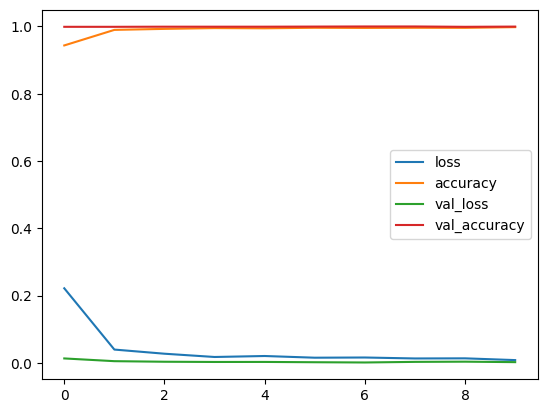

In [14]:
pd.DataFrame(history.history).plot()

## Testing

In [15]:
test_data = "/content/vegetable-image-dataset/Vegetable Images/test"

In [16]:
test_gen = ImageDataGenerator()
test_image_generator = test_gen.flow_from_directory(
                                            test_data,
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode='categorical')

Found 3000 images belonging to 15 classes.


In [17]:
model = keras.models.load_model('/content/efficinentB0_best.h5')

In [19]:
model.evaluate(test_image_generator)

94/94 [==============================] - 8s 73ms/step - loss: 0.0028 - accuracy: 0.9993


[0.002812911057844758, 0.9993333220481873]

In [47]:
from tensorflow.keras.preprocessing.image import load_img

image_path = '/content/vegetable-image-dataset/Vegetable Images/test/Tomato/1004.jpg'
image = load_img(image_path, target_size = (224, 224))
x = np.array(image)
X = np.array([x])

In [48]:
from tensorflow.keras.applications.efficientnet import preprocess_input

X = preprocess_input(X)

In [49]:
pred = model.predict(X)
pred

1/1 [==============================] - 0s 24ms/step


array([[1.70271037e-14, 3.05340157e-16, 2.49489873e-10, 2.06616907e-12,
        2.31541132e-13, 1.01436874e-16, 1.19260937e-15, 2.90752331e-17,
        2.13627334e-13, 1.63641800e-19, 9.93584801e-17, 1.19875787e-15,
        3.82080548e-16, 2.31502816e-12, 1.00000000e+00]], dtype=float32)

In [50]:
class_labels = ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']
print("Class Labels:", class_labels)

Class Labels: ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


In [51]:
preds = dict(zip(class_labels, pred[0]))

In [54]:
max_value = max(preds[label] for label in class_labels)
max_label = [label for label in class_labels if preds[label] == max_value]

print(f"Ini adalah buah : {max_label}")

Ini adalah buah : ['Tomato']


## Menyimpan Model

In [32]:
import pathlib
# Menyimpan model dalam format SavedModel
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

# Convert SavedModel menjadi vegetable.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('vegetable.tflite')
tflite_model_file.write_bytes(tflite_model)

16703772

In [33]:
%cd /content

/content


In [34]:
!zip -r veg_model.zip saved_model/

  adding: saved_model/ (stored 0%)
  adding: saved_model/assets/ (stored 0%)
  adding: saved_model/fingerprint.pb (stored 0%)
  adding: saved_model/saved_model.pb (deflated 91%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: saved_model/variables/variables.index (deflated 74%)


In [35]:
from google.colab import files
files.download('veg_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>